In this project we wanted to show where a plane flew through a storm that was producing hail and the reported size of the hail at the surface. Thus, this code reads in radar data, flight tracking data, and hail size data and plots them together on a map. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc4
from datetime import datetime, timedelta
import pytz
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import USCOUNTIES
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import csv
import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Set Directories and Files

HailDirectory = '/Local/Hail/Directory/'
SPOLDirectory = '/Local/Radar/Directory/'
FlightDirectory = '/Local/Flight/Directory/
PlotDirectory = '/Local/Plot/Directory/'

HailFile = 'Hail_20000629.csv'
RadarFile = 'cfrad.20000629_233038.300_SPOL_PPI.nc'
FlightFile = '761.nc'


In [3]:
# Read in hail report data
    
Data = np.genfromtxt(HailDirectory + HailFile, usecols=(1, 2, 4, 5), skip_header=1, delimiter=',', dtype=('f','f','f','f'), 
                                     names=('Time', 'HailSize', 'HailLat', 'HailLong'))

HailTime = Data['Time']
HailSize = Data['HailSize']*25.4
HailLat = Data['HailLat']
HailLong = Data['HailLong']


In [4]:
# Isolate reports associated with our storm

Indices = np.squeeze(np.array(np.where(HailLong <= -100.5)))[1:-1]

HailTime = HailTime[Indices]
HailSize = HailSize[Indices]
HailLat = HailLat[Indices]
HailLong = HailLong[Indices]

nHail = len(HailTime)


In [5]:
# Convert to time to gmt

UTC = pytz.timezone('UTC')
Central = pytz.timezone('US/Central')

DateTimes = []
Times = []
#Times = np.empty(len(Indices))
for i in range(0, nHail):
    Temp = datetime(2000, 6, 29, int(str(HailTime[i])[0:2]), int(str(HailTime[i])[2:4]))
    Temp = Central.localize(Temp)
    Temp = Temp.astimezone(UTC)
    
    DateTimes = np.append(DateTimes, Temp)
    if Temp.hour < 10:
        Hour = '0' + str(Temp.hour)
    else:
        Hour = str(Temp.hour)
    
    if Temp.minute < 10:
        Minute = '0' + str(Temp.minute)
    else:
        Minute = str(Temp.minute)
     
    Times = np.append(Times, int(Hour + Minute))
    
print(Times)
print(DateTimes)


[2205. 2252. 2310. 2319. 2330.]
[datetime.datetime(2000, 6, 29, 22, 5, tzinfo=<UTC>)
 datetime.datetime(2000, 6, 29, 22, 52, tzinfo=<UTC>)
 datetime.datetime(2000, 6, 29, 23, 10, tzinfo=<UTC>)
 datetime.datetime(2000, 6, 29, 23, 19, tzinfo=<UTC>)
 datetime.datetime(2000, 6, 29, 23, 30, tzinfo=<UTC>)]


In [6]:
# Load radar data, create filter, grid, and determine lat and longs

# Load
SPOL = pyart.io.read_cfradial(SPOLDirectory + SPOLFile)

# Create filter
GateFilter = pyart.correct.GateFilter(SPOL)
GateFilter.exclude_above('PARTICLE_ID', 14)
GateFilter.exclude_equal('COMBINED_CENSOR_FLAG', 1)

# Grid data
grid_limits = ((0, 5000), (-265000, 85000), (0, 450000))   
grid_shape = (11, 601, 901) 
Grid = pyart.map.grid_from_radars(SPOL, grid_shape=grid_shape, grid_limits=grid_limits, weighting_function='Cressman', 
                                  roi_func='dist', z_factor=0.055, xy_factor=0.025, min_radius=250, gatefilters=GateFilter)

# Determine lat, lons
xPlot = Grid.x['data']
yPlot = Grid.y['data']
xPlot, yPlot = np.meshgrid(xPlot, yPlot)

LonGrid, LatGrid = pyart.core.cartesian_to_geographic(xPlot, yPlot, 
                                                      projparams=ccrs.AzimuthalEquidistant(central_longitude=Grid.get_projparams()['lon_0'], 
                                                                                           central_latitude=Grid.get_projparams()['lat_0']))



In [7]:
# Load in flight path data

DirectoryFile = FlightDirectory + FlightFile

ncfile = nc4.Dataset(DirectoryFile, 'r')
FlightDay = np.array(ncfile.variables['Day'])[:]
FlightMonth = np.array(ncfile.variables['Month'])[:]
FlightYear = np.array(ncfile.variables['Year'])[:]
FlightRawTimes = np.array(ncfile.variables['Times'])[:]
FlightLatitude = np.array(ncfile.variables['Latitude'])[:]
FlightLongitude = np.array(ncfile.variables['Longitude'])[:]
ncfile.close()

BaseTime = datetime(2000, 6, 29, 0, 0, 0)
    
FlightTimes = []
PlotFlightTimes = []
for t in range(0, len(FlightRawTimes)):
    FlightTimes = np.append(FlightTimes, BaseTime + timedelta(seconds = float(FlightRawTimes[t])))
    
    PlotFlightTimes = np.append(PlotFlightTimes, int(str(FlightTimes[-1].hour) + str(FlightTimes[-1].minute)))


In [8]:
# Determine location of hail in Lon and Lat Grid

HailLongIndex = np.zeros(nHail, dtype=int)
HailLatIndex = np.zeros(nHail, dtype=int)

for h in range(0, nHail):
    HailLatIndex[h] = np.squeeze(np.array(np.nanargmin(np.absolute(np.subtract(LatGrid[:, 0], 
                                                                         np.ones_like(LatGrid[:, 0])*HailLat[h])))))
    HailLongIndex[h] = np.squeeze(np.array(np.nanargmin(np.absolute(np.subtract(LonGrid[0, :], 
                                                                         np.ones_like(LonGrid[0, :])*HailLong[h]))))) 


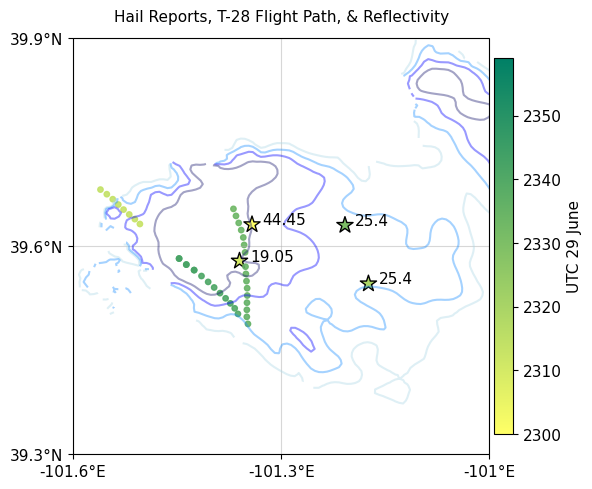

In [11]:
# Plot hail reports

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(1,1,1, projection=ccrs.AzimuthalEquidistant(central_longitude=Grid.get_projparams()['lon_0'], 
                                                                 central_latitude=Grid.get_projparams()['lat_0']))
ax.set_title('Hail Reports, T-28 Flight Path, & Reflectivity', fontsize=11, y=1.02)
ax.set_extent([-101.6, -101, 39.9, 39.3], crs=ccrs.AzimuthalEquidistant(central_longitude=Grid.get_projparams()['lon_0'], 
                                                                    central_latitude=Grid.get_projparams()['lat_0']))
ax.add_feature(cfeature.STATES.with_scale('50m'))
ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='dimgray')
ax.contour(LonGrid, LatGrid, np.ma.masked_invalid(np.atleast_2d(Grid.fields["DBZ_F"]["data"][2])), levels=[10, 20, 30, 40], 
           colors=['lightblue', 'dodgerblue', 'blue', 'midnightblue'], alpha=0.4)
C1 = ax.scatter(LonGrid[HailLatIndex[1::], HailLongIndex[1::]], LatGrid[HailLatIndex[1::], HailLongIndex[1::]], c=Times[1::], s=150, 
               vmin=2300, vmax=2359, marker='*', cmap='summer_r', edgecolors='black')
ax.scatter(FlightLongitude, FlightLatitude, c=PlotFlightTimes, s=15, vmin=2300, vmax=2359, alpha=0.9, cmap='summer_r')
for h in range(1, nHail):
    ax.annotate(str(HailSize[h]), (LonGrid[HailLatIndex[h], HailLongIndex[h]]+0.015, LatGrid[HailLatIndex[h], HailLongIndex[h]]), fontsize=11)
    #ax.annotate(str(Times[h]), (LonGrid[HailLatIndex[h], HailLongIndex[h]], LatGrid[HailLatIndex[h], HailLongIndex[h]]))
cbar1 = plt.colorbar(C1, pad=0.01, ax=ax, shrink=0.9)
cbar1.ax.set_ylabel('UTC 29 June', fontsize=11)
cbar1.ax.tick_params(labelsize=11)
ax.set_xticks([-101.6, -101.3, -101], crs=ccrs.AzimuthalEquidistant(central_longitude=Grid.get_projparams()['lon_0'], 
                                                                                central_latitude=Grid.get_projparams()['lat_0']))
ax.set_xticklabels(['-101.6' + u"\u00b0" + 'E', '-101.3' + u"\u00b0" + 'E', '-101' + u"\u00b0" + 'E'], fontsize=11)
ax.set_yticks([39.9, 39.6, 39.3], crs=ccrs.AzimuthalEquidistant(central_longitude=Grid.get_projparams()['lon_0'], 
                                                                                central_latitude=Grid.get_projparams()['lat_0']))
ax.set_yticklabels(['39.9' + u"\u00b0" + 'N', '39.6' + u"\u00b0" + 'N', '39.3' + u"\u00b0" + 'N'], fontsize=11)
ax.grid(True, alpha=0.5)

fig.tight_layout()
plt.savefig(PlotDirectory + 'Figure2.png', facecolor='white', dpi=300)
plt.show()
